In [1]:
library(cowplot)
library(dplyr)
library(ggplot2)
library(tibble)
library(Seurat)
library(questionr)

source("./reg-deg.fun.R")
source("./dis.fun.R")
source("./pie.fun.R")

Registered S3 methods overwritten by 'tibble':
  method     from  
  format.tbl pillar
  print.tbl  pillar


********************************************************

Note: As of version 1.0.0, cowplot does not change the

  default ggplot2 theme anymore. To recover the previous

  behavior, execute:
  theme_set(theme_cowplot())

********************************************************



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: grid

ComplexHeatmap version 2.2.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite:
Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
  genomic data. Bioinformati

In [2]:
###--------------------------------------------------------------------------------
## Combine the DEG res
cbnres <- readRDS(file = "./load_files/DEG_res.rds") %>%
            filter(p_val_adj <= 0.01 & avg_logFC >= 0.2 & ratio_fc >= 1.05)
mars <- split(cbnres, cbnres$cluster) %>%
            lapply(., function(x) split(x$gene, x$region))
exp_list <- readRDS(file = "./load_files/Expgenes_res.rds")


## Make sure the markers are all in the exp list
for (ii in names(mars)){
    sapply(names(mars[[ii]]), function(reg) length(setdiff(mars[[ii]][[reg]], exp_list[[ii]])) != 0) %>% 
           print()
}

   FC    OC   MSC    TC 
FALSE FALSE FALSE FALSE 
   FC    OC   MSC    TC 
FALSE FALSE FALSE FALSE 
   FC    OC   MSC    TC 
FALSE FALSE FALSE FALSE 
   FC    OC   MSC    TC 
FALSE FALSE FALSE FALSE 
   FC    OC   MSC    TC 
FALSE FALSE FALSE FALSE 
   FC    OC   MSC    TC 
FALSE FALSE FALSE FALSE 
   FC    OC   MSC    TC 
FALSE FALSE FALSE FALSE 
   FC    OC   MSC    TC 
FALSE FALSE FALSE FALSE 
   FC    OC   MSC    TC 
FALSE FALSE FALSE FALSE 
   FC    OC   MSC    TC 
FALSE FALSE FALSE FALSE 
   FC    OC   MSC    TC 
FALSE FALSE FALSE FALSE 
   FC    OC   MSC    TC 
FALSE FALSE FALSE FALSE 
   FC    OC   MSC    TC 
FALSE FALSE FALSE FALSE 
   FC    OC   MSC    TC 
FALSE FALSE FALSE FALSE 
   FC    OC   MSC    TC 
FALSE FALSE FALSE FALSE 
   FC    OC   MSC    TC 
FALSE FALSE FALSE FALSE 
   FC    OC   MSC    TC 
FALSE FALSE FALSE FALSE 
   FC    OC   MSC    TC 
FALSE FALSE FALSE FALSE 
   FC    OC   MSC    TC 
FALSE FALSE FALSE FALSE 


In [3]:
###--------------------------------------------------------------------------------
## Combine the DEG res
load("./load_files/Disease_genes_v3.Rdata") ## alltb, alllist
load(file = "./load_files/Reg-DEG_expr_avgs.Rdata")
## avgs, ratios, 
alltb <- alltb[intersect(rownames(alltb), rownames(avgs)), ]

degres <- readRDS(file = paste0("./load_files/", "DEG_res.rds")) %>%
            filter(gene %in% rownames(alltb)) %>%
            filter(p_val_adj <= 0.01 & avg_logFC >= 0.25 & ratio_fc >= 1.25 & pct.1 >= 0.2)
marres <- readRDS(file = paste0("./load_files/", "Marker_res.rds"))%>%
            filter(gene %in% rownames(alltb)) %>%
            filter(p_val_adj <= 0.01 & avg_logFC >= 0.25 & ratio_fc >= 1.25 & pct.1 >= 0.2)

## Generate dem martrices
allgps <- c("NESC", "vRG_early", "vRG_late", "oRG", 
            "IPC EOMES NEUROG1", "IPC EOMES NHLH1", 
            "ExN L6B", "ExN L6CT", "ExN upper", "MGE-InN", "CGE-InN", 
            "gIPC", "aIPC", "oIPC", "Astro", "OPC")
dem_mats <- lapply(c("FC", "MSC", "TC", "OC"), function(lb) {
        dem_mat <- lapply(allgps, function(gp) {
            mars <- marres %>%
                    filter(cluster %in% gp & region %in% lb) %>%
                    filter(!grepl("^LOC", gene))
            degs <- degres %>%
                    filter(cluster %in% gp & region %in% lb) %>%
                    filter(!grepl("^LOC", gene))
            dem <- intersect(mars$gene, degs$gene)
            dem_value <- ifelse(rownames(alltb) %in% dem, 1, 0) %>%
                    setNames(., rownames(alltb))
            return(dem_value)
            }) %>%
            setNames(., allgps) %>%
            as.data.frame(., check.names = FALSE) %>%
            as.matrix()
        colnames(dem_mat) <- paste0(lb, "|", colnames(dem_mat))
        return(dem_mat)
        }) %>%
        do.call(cbind, .)


## Top dems
demtops <- lapply(c("FC", "MSC", "TC", "OC"), function(lb) {
    lb_genes <- lapply(allgps, function(gp) {
        mars <- marres %>%
                filter(cluster %in% gp & region %in% lb) %>%
                filter(!grepl("^LOC", gene)) %>%
                top_n(25, wt = ratio_fc)
        degs <- degres %>%
                filter(cluster %in% gp & region %in% lb) %>%
                filter(!grepl("^LOC", gene)) %>%
                top_n(25, wt = ratio_fc)
        dem <- intersect(mars$gene, degs$gene)
        return(dem)
        }) %>%
        unlist() %>% unique()
    print(length(lb_genes))
    return(lb_genes)
    }) %>%
    setNames(., c("FC", "MSC", "TC", "OC"))
demtops

[1] 26
[1] 13
[1] 17
[1] 17


$FC
 [1] "ID4"      "CDON"     "EMX1"     "HEY1"     "EFNA5"    "S100A10" 
 [7] "HIST1H1B" "OLFM2"    "SPARCL1"  "EPHB6"    "POU3F2"   "PDLIM7"  
[13] "MDK"      "SATB1"    "ARPP21"   "LMO3"     "SATB2"    "NUAK1"   
[19] "PPP1R1B"  "RORB"     "MYO16"    "CDH8"     "GRM7"     "ADAMTSL3"
[25] "DLX2"     "APOE"    

$MSC
 [1] "EMX2"   "HEY1"   "HMGN5"  "BCL11B" "AKT3"   "SSBP2"  "SYBU"   "MLF1"  
 [9] "CDH13"  "NRP2"   "ACTN2"  "GRIN2A" "NRGN"  

$TC
 [1] "FGFR3"  "FSTL5"  "SPOCK2" "NR2F1"  "LMO3"   "PRKCB"  "NPTX1"  "PLK2"  
 [9] "HIVEP2" "CDH13"  "SNCA"   "MLF1"   "PSD3"   "CHRM3"  "RGS6"   "MET"   
[17] "DPYD"  

$OC
 [1] "CENPW"    "FGFR3"    "IFT57"    "HIST1H1B" "RAB8B"    "HES1"    
 [7] "HEY1"     "CENPM"    "MCM7"     "FDFT1"    "EMX1"     "BCL11A"  
[13] "NPTX1"    "TENM2"    "PAPPA2"   "THBS1"    "SEZ6L"

Warning message:
“Removed 256 rows containing missing values (geom_point).”


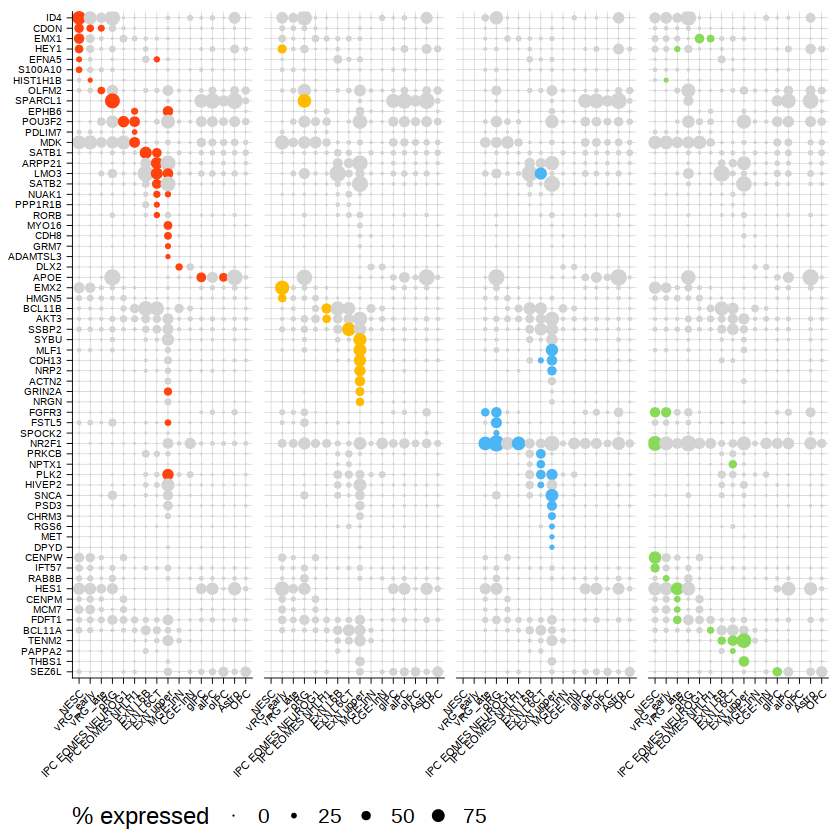

In [4]:
## Plot gene expression
genes <- unlist(demtops) %>% unique()

p <- CirclePlot.horizontal(avg = avgs[rownames(alltb), ], 
                      ratio = ratios[rownames(alltb), ], 
                      features = genes, file_name = "Region_DEGs_disease_genes.pdf", 
                      dot.min = 0, dot.scale = 4, scale.by = "radius", 
                      shape = 16, cluster.order = allgps, stroke.col = "black", 
                      stroke.size = 0.5, col.min = -2.5, col.max = 2.5, scale = TRUE, 
                      scale.min = NA, scale.max = NA, mask.matrix = dem_mats[rownames(alltb), ], 
                      return.plot = TRUE, width.scale = 0.5, height.base = 1.5, font.scale = c(0.9, 0.6), 
                      height.unit = 0.065)
options(jupyter.plot_scale = 1)
p

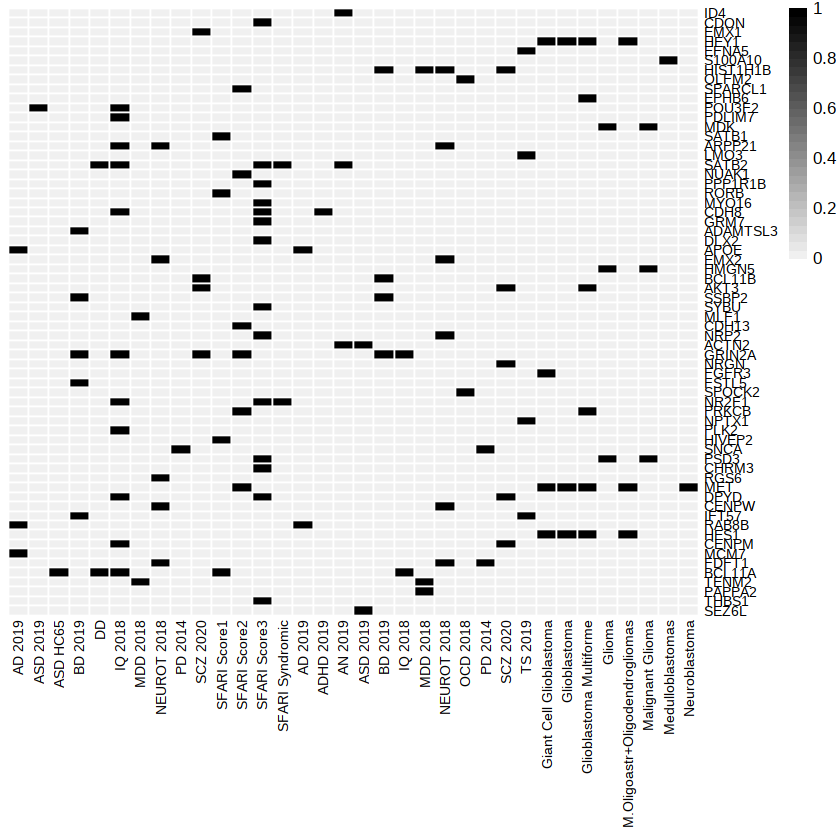

In [5]:
dis_df <- read.csv(file = paste0("./load_files/", "DiseaseOrderFinal.csv"), stringsAsFactors = FALSE)
dis_ord <- dis_df$Disease.listname
top_anno <- alltb[genes, dis_ord]
top_anno <- top_anno[, colSums(top_anno) > 0]
colnames(top_anno) <- extract_field(colnames(top_anno), -1, "::")

## Disease gene annotation
##pdf(paste0("./report/", "Region_DEGs_disease_genes_annot.pdf"), width = 4, height = 7)
pheatmap::pheatmap(top_anno, cluster_rows =FALSE, 
                   cluster_cols = FALSE, 
                   color = colorRampPalette(c("#f0f0f0", "#000000"))(30), 
                   border_color = "white", 
                   show_rownames = TRUE, 
                   show_colnames = TRUE, 
                   fontsize_col = 8, 
                   fontsize_row = 8, 
                   angle_col = 90)
##dev.off()

In [6]:
## All DEMs
dems <- lapply(c("FC", "MSC", "TC", "OC"), function(lb) {
    lb_genes <- lapply(allgps, function(gp) {
        mars <- marres %>%
                filter(cluster %in% gp & region %in% lb) %>%
                filter(!grepl("^LOC", gene))
        degs <- degres %>%
                filter(cluster %in% gp & region %in% lb) %>%
                filter(!grepl("^LOC", gene)) 
        dem <- intersect(mars$gene, degs$gene)
        return(dem)
        }) %>%
        unlist() %>% unique()
    print(length(lb_genes))
    return(lb_genes)
    }) %>%
    setNames(., c("FC", "MSC", "TC", "OC"))
dems

[1] 90
[1] 31
[1] 37
[1] 27


$FC
 [1] "NNAT"     "ID4"      "CDON"     "EMX1"     "HEY1"     "PAX6"    
 [7] "EFNA5"    "CDK2AP1"  "S100A10"  "IDH2"     "NT5DC2"   "BCL7C"   
[13] "EIF5A"    "HIST1H1B" "OLFM2"    "TSPAN7"   "SPARCL1"  "POU3F2"  
[19] "CDK6"     "EPHB6"    "PDLIM7"   "MDK"      "SATB1"    "THSD7A"  
[25] "ARPP21"   "LMO3"     "NBEA"     "SATB2"    "NUAK1"    "PPP1R1B" 
[31] "GABBR2"   "RORB"     "GUCY1A2"  "PCDH17"   "PCDH10"   "GPR85"   
[37] "FBXW7"    "NRCAM"    "STXBP5"   "DOCK4"    "SCN2A"    "SMARCA2" 
[43] "GRM5"     "CXXC4"    "ATP1A3"   "CALN1"    "LSAMP"    "PLK2"    
[49] "MYO16"    "GRIN2A"   "SCN9A"    "CACNA1A"  "PSD"      "SNAP91"  
[55] "MEIS2"    "LRRC4C"   "STX1A"    "SLC2A13"  "CDH8"     "CELF4"   
[61] "STMN3"    "SLITRK5"  "BIN1"     "RABGAP1L" "STYK1"    "SPATS2L" 
[67] "FNIP2"    "AGAP2"    "ENOX1"    "KLF6"     "NEGR1"    "ACVR2A"  
[73] "GRM7"     "DPP10"    "NEBL"     "GRID2"    "PCDH19"   "PPM1E"   
[79] "FGF14"    "ADAMTSL3" "KIT"      "CNTN4"    "TMEM200C" "GALNT2"  
[85] "FSTL5"    "TSHZ3"    "PTPRT"    "DLX2"     "APOE"     "DNER"    

$MSC
 [1] "EMX2"     "HEY1"     "CLU"      "SKA2"     "RNPS1"    "HMGN5"   
 [7] "CTNNB1"   "UBE2N"    "ZNF827"   "PPP2CA"   "PCNP"     "SPARCL1" 
[13] "BCL11B"   "AKT3"     "SSBP2"    "PICALM"   "SYNE1"    "SYBU"    
[19] "MLF1"     "GUCY1A2"  "CDH13"    "NRP2"     "ACTN2"    "PCDH7"   
[25] "ZEB2"     "GRIN2A"   "CADM2"    "NRGN"     "SLC25A27" "OPCML"   
[31] "CUX1"    

$TC
 [1] "FGFR3"  "NR2F1"  "FSTL5"  "NTRK2"  "UBE2H"  "FADS1"  "SPOCK2" "DPP6"  
 [9] "LMO3"   "PRKCB"  "NPTX1"  "AUTS2"  "PLK2"   "HIVEP2" "CAMK4"  "CDH13" 
[17] "GPX1"   "SNCA"   "MLF1"   "FBXW7"  "CHD5"   "PSD3"   "NCOA1"  "NRIP1" 
[25] "THSD7A" "CHRM3"  "EPHA3"  "ROBO2"  "NRP2"   "NR4A2"  "TOX3"   "CUX1"  
[33] "RGS6"   "MET"    "DPYD"   "LCORL"  "DIPK2A"

$OC
 [1] "CENPW"    "FGFR3"    "IFT57"    "NR2F1"    "HIST1H1B" "RAB8B"   
 [7] "HES1"     "HEY1"     "CENPM"    "MCM7"     "FDFT1"    "H1F0"    
[13] "EMX1"     "NFIX"     "BCL11A"   "TENM2"    "NPTX1"    "RUNX1T1" 
[19] "PAPPA2"   "SIPA1L2"  "RBPJ"     "THBS1"    "NTM"      "NTRK3"   
[25] "NLGN1"    "TSHZ3"    "SEZ6L"

Warning message:
“Removed 660 rows containing missing values (geom_point).”


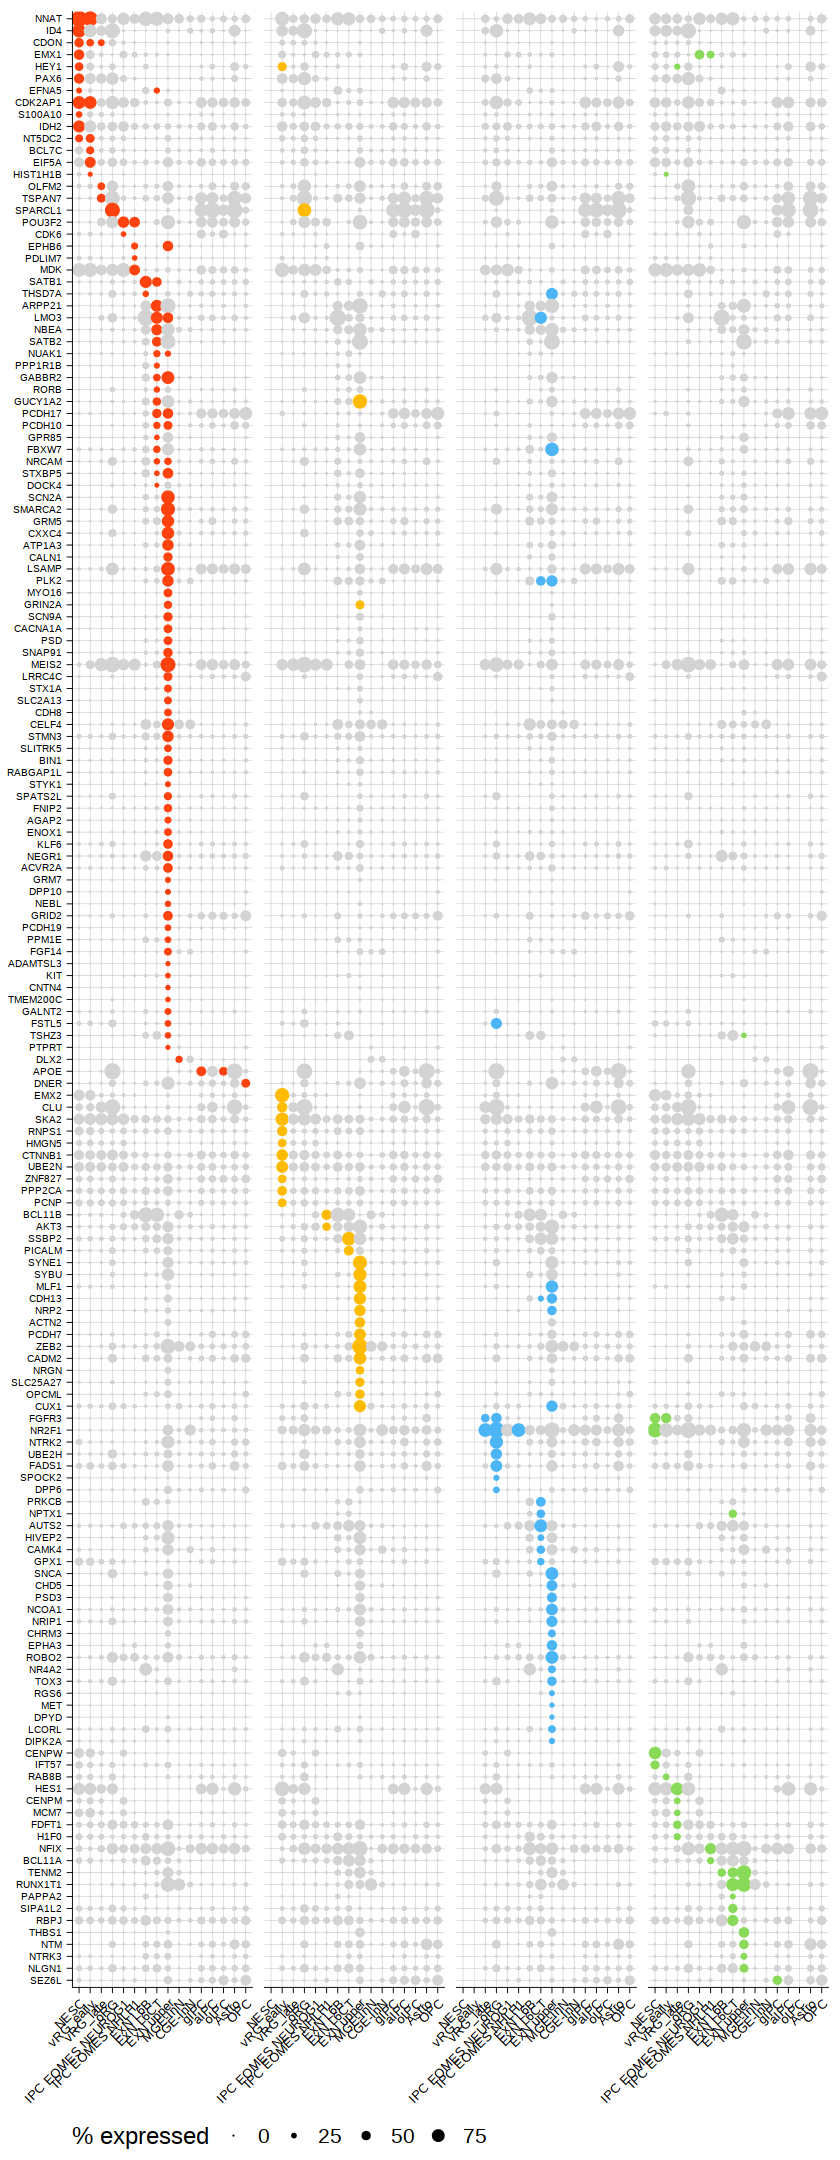

In [7]:
genes2 <- unlist(dems) %>% unique()
p2 <- CirclePlot.horizontal(avg = avgs[rownames(alltb), ], 
                            ratio = ratios[rownames(alltb), ], 
                            features = genes2, 
                            file_name = "Region_DEGs_disease_genes_all.pdf", 
                            dot.min = 0, dot.scale = 4, scale.by = "radius", 
                            shape = 16, cluster.order = allgps, stroke.col = "black", 
                            stroke.size = 0.5, col.min = -2.5, col.max = 2.5, 
                            scale = TRUE, scale.min = NA, scale.max = NA, 
                            mask.matrix = dem_mats[rownames(alltb), ], 
                            return.plot = TRUE, width.scale = 0.5, 
                            height.base = 1.5, font.scale = c(1, 0.6), height.unit = 0.08)
options(repr.plot.width=7, repr.plot.height=18)
p2

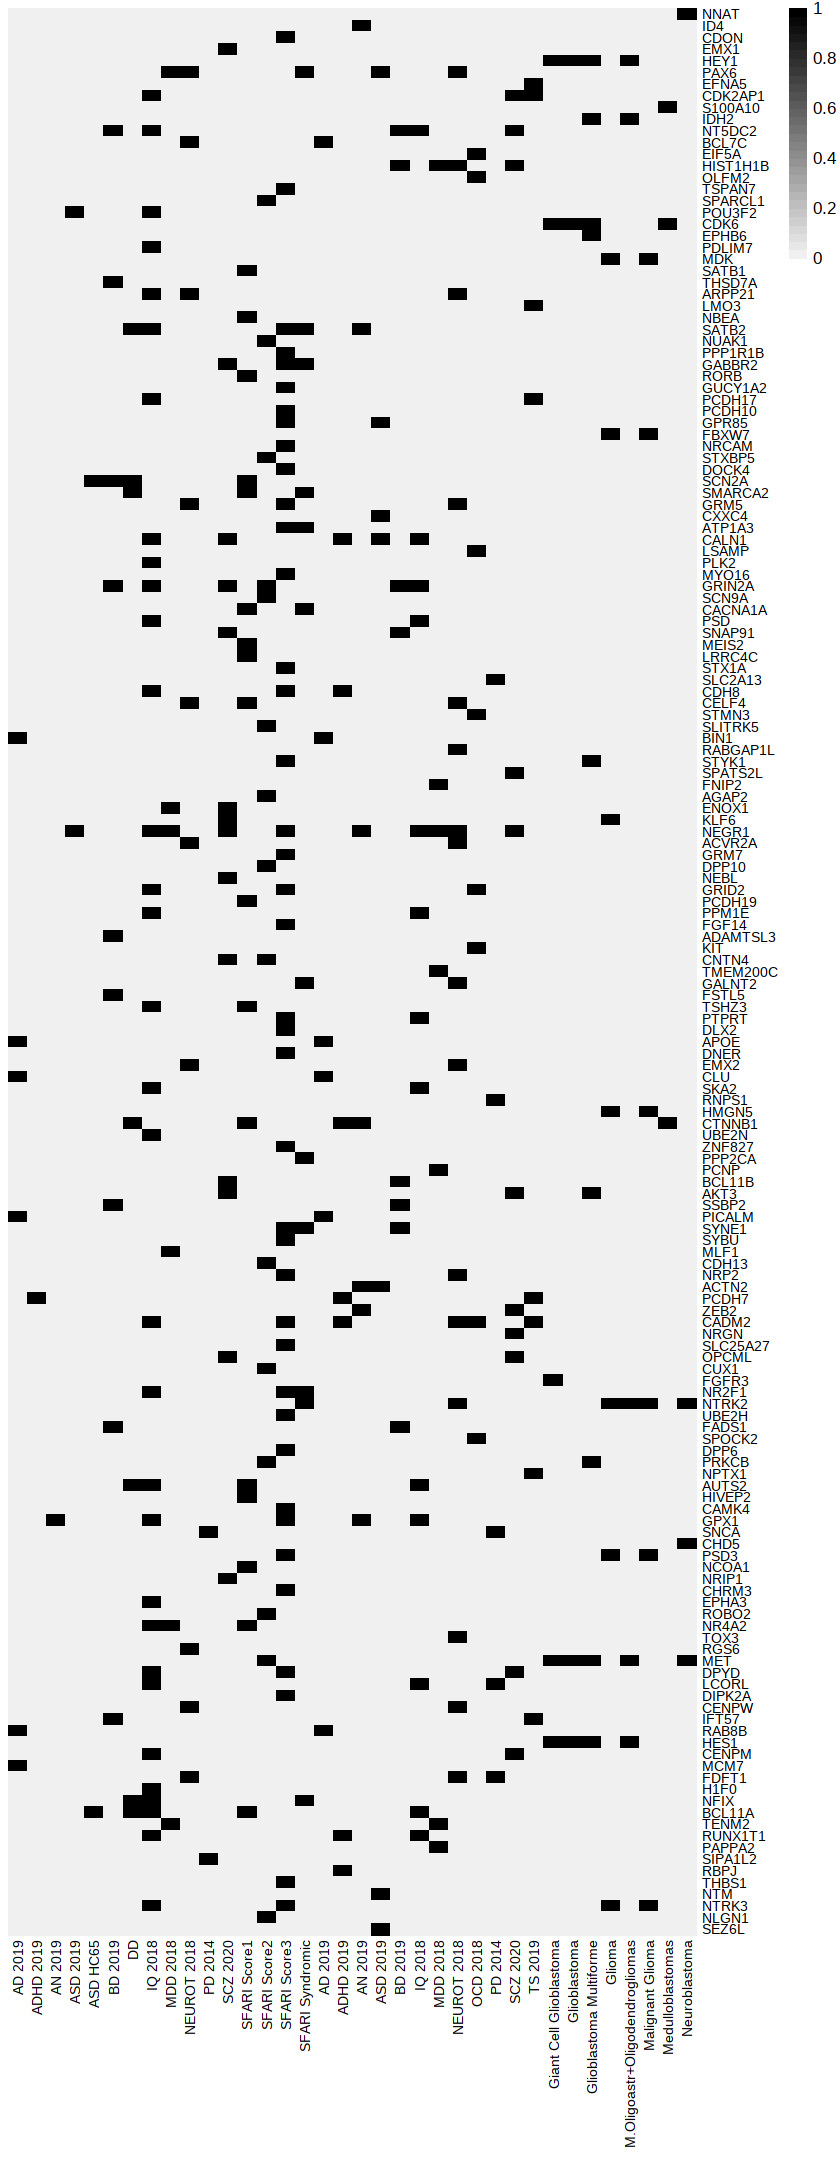

In [8]:
all_anno <- alltb[genes2, dis_ord]
all_anno <- all_anno[, colSums(all_anno) > 0]
colnames(all_anno) <- extract_field(colnames(all_anno), -1, "::")

options(repr.plot.width=7, repr.plot.height=18)
## Disease gene annotation
##pdf(paste0("./report/", "Region_DEGs_disease_genes_all_annot.pdf"), width = 4, height = 12)
pheatmap::pheatmap(all_anno, 
                   cluster_rows =FALSE, 
                   cluster_cols = FALSE, 
                   color = colorRampPalette(c("#f0f0f0", "#000000"))(30), 
                   border_color = "white", 
                   show_rownames = TRUE, 
                   show_colnames = TRUE, 
                   fontsize_col = 8, 
                   fontsize_row = 8, 
                   angle_col = 90)
##dev.off()

In [9]:
sessionInfo()

R version 3.6.1 (2019-07-05)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux Server 7.9 (Maipo)

Matrix products: default
BLAS:   /gpfs/ycga/home/sm2726/packages/R_versions/R-3.6.1/lib64/R/lib/libRblas.so
LAPACK: /gpfs/ycga/home/sm2726/packages/R_versions/R-3.6.1/lib64/R/lib/libRlapack.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] tidyr_1.1.3          ggforce_0.3.1        scatterpie_0.1.5    
 [4] AUCell_1.8.0         BiocParallel_1.20.1  foreach_1.5.0       
 [7] ComplexHeatmap_2.2.0 questionr_0.7.7